<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Installation of Libraries </h1>

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Download Dataset from External Source </h1>

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Importing Libraries </h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pathlib
import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import applications
import seaborn as sns
import cv2
from PIL import Image
from tensorflow.keras import backend as K
from pycocotools.coco import COCO

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow_hub as hub

import zipfile
import shutil 
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras  import preprocessing

print("Importing libraries completed.")

Importing libraries completed.


<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Custom Functions </h1>

In [2]:
# Configuration
class Config:
     
    save_model = False
     
    epochs = 20
     
    batch_size = 32
    

In [3]:
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)


seed_everything()
print('Seeding completed')

Seeding completed


<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Reading Data </h1>

In [4]:
 


def from_kaggle_dir(parent_path):
    print('From Kaggle Directory')
    sub_dir = os.listdir(parent_path)
    sub_path = {}
    
    if len(sub_dir) == 3:
        for i in sub_dir:
            sub_path[i] = os.path.join(parent_path, i)
    elif len(sub_dir) == 2:
        for i in sub_dir:
            sub_path[i] = os.path.join(parent_path, i)
        sub_path['val'] = None
    else : 
        sub_path['test'] = None
        sub_path['val'] = None 
        for i in sub_dir:
            sub_path[i] = os.path.join(parent_path, i)
        

    return  sub_path
     

  

In [5]:

PATH = from_kaggle_dir(
    parent_path='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation')

PATH

From Kaggle Directory


{'test': '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test',
 'val': None,
 'README.txt': '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/README.txt',
 'valid': '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid',
 'train': '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train'}

In [6]:
train_dir = os.path.join(PATH['train'], '')
val_dir  =  os.path.join(PATH['valid'], '')  
test_dir =  os.path.join(PATH['test'], '')  

In [7]:
train_annotation_file = os.path.join(train_dir, '_annotations.coco.json')
val_annotation_file  =  os.path.join(val_dir, '_annotations.coco.json')  
test_annotation_file =  os.path.join(test_dir, '_annotations.coco.json') 

In [8]:
train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Data Inspection </h1>

In [9]:
print(len(os.listdir(train_dir))) 
print(len(os.listdir(val_dir)))
print(len(os.listdir(test_dir)))
print(os.listdir(train_dir)[:4])

1503
430
216
['1687_jpg.rf.4f709c4e23ae176707e3d20f2f507e07.jpg', '2489_jpg.rf.856d32b795d6bedeec07c32d7376e33d.jpg', '2881_jpg.rf.62fea2620f0c00fa99bdd173ab6ebbd2.jpg', '2020_jpg.rf.7f99b1f1a4fb216442b3f075d743344d.jpg']


In [10]:
train_coco, val_coco, test_coco

(<pycocotools.coco.COCO at 0x7e79631f9f00>,
 <pycocotools.coco.COCO at 0x7e79631fa1d0>)

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Data Visualization </h1>

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Data Preprocessing </h1>

In [11]:
def load_image_and_mask(coco, image_dir, image_id):
     image_info = coco.loadImgs(image_id)[ 0]
     image_path = os.path.join(image_dir, image_info[ 'file_name' ])
     image = Image. open(image_path)
     image = np.array(image)
     ann_ids = coco.getAnnIds(imgIds=image_id)
     anns = coco.loadAnns(ann_ids)
     mask = np.zeros((image_info[ 'height' ], image_info[ 'width' ]))
     for ann in anns:
         mask = np.maximum(mask, coco.annToMask(ann))
     return image, mask

def create_tf_dataset(coco, image_dir, image_ids):
    def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)
    return tf.data.Dataset.from_generator(generator, 
                                       output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), 
                                                         tf.TensorSpec(shape=(None, None), dtype=tf.uint8)))

In [12]:
train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
 

In [13]:
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
 

In [14]:
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())
 

In [15]:
def preprocess(image, mask):
 image = tf.image.resize(image, ( 256, 256))
 mask = tf.expand_dims(mask, axis=- 1)
 mask = tf.image.resize(mask, ( 256, 256))
 image = tf.cast(image, tf.float32) / 255.0
 return image, mask

<h1 id="ergdfffggs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center"> Data Postprocessing </h1>

In [16]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [17]:
def visualize_dataset(dataset, num_samples=5):
 for i, (image, mask) in enumerate(dataset.take(num_samples)):
     plt.figure(figsize=( 10, 5))
     plt.subplot(1, 2, 1)
     plt.imshow(image.numpy())
     plt.title("Image")
     plt.axis( "off")
     plt.subplot(1, 2, 2)
     plt.imshow(mask.numpy().squeeze(), cmap="gray")
     plt.title("Mask")
     plt.axis( "off")
     plt.show()

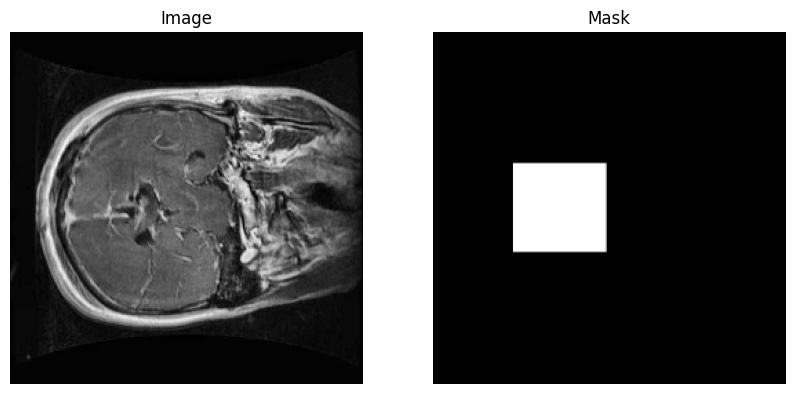

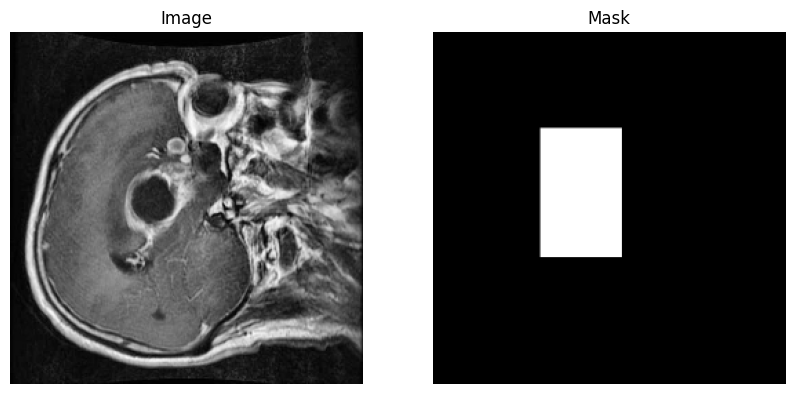

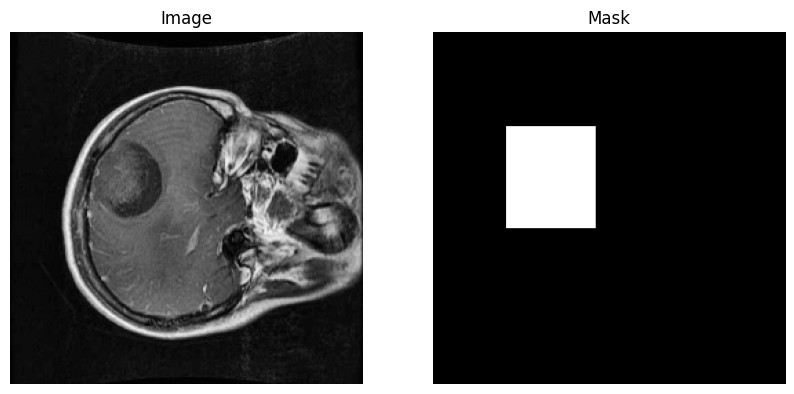

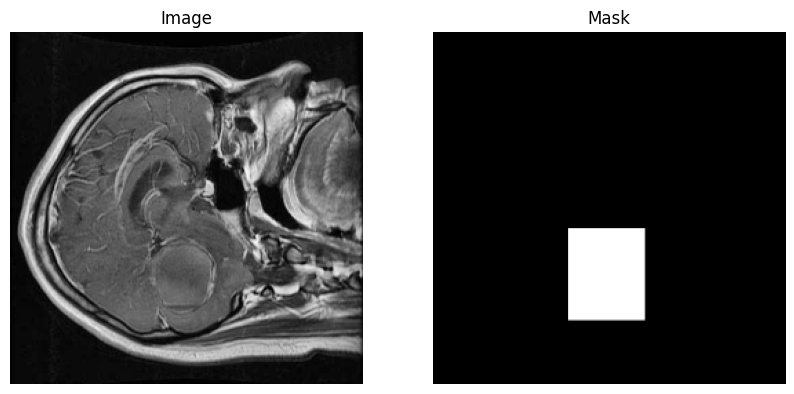

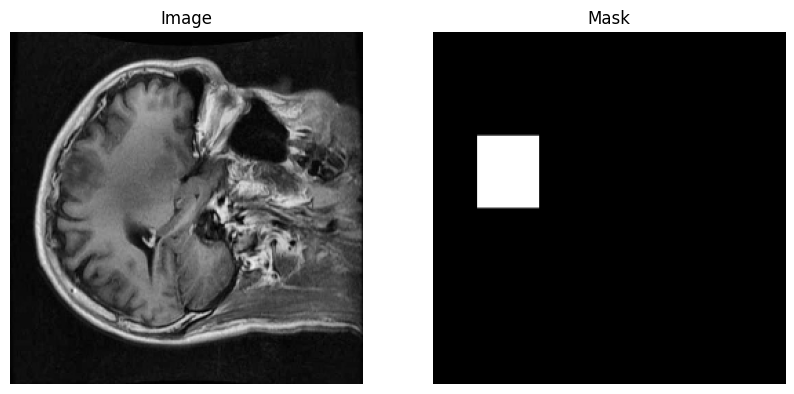

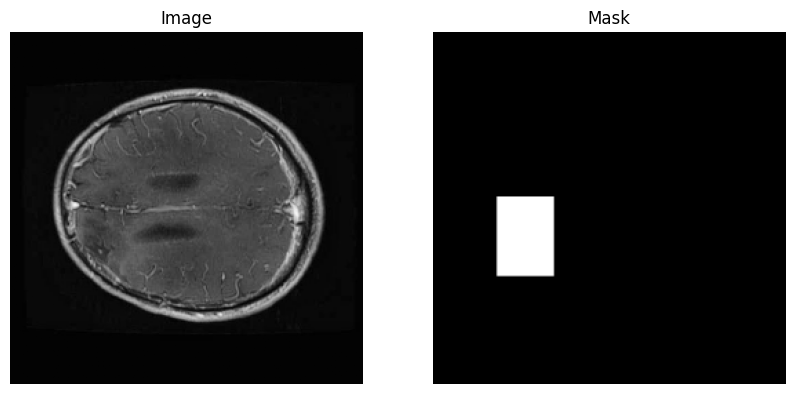

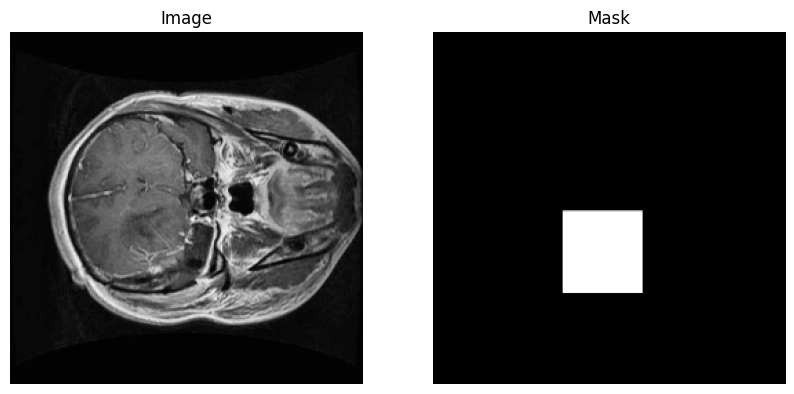

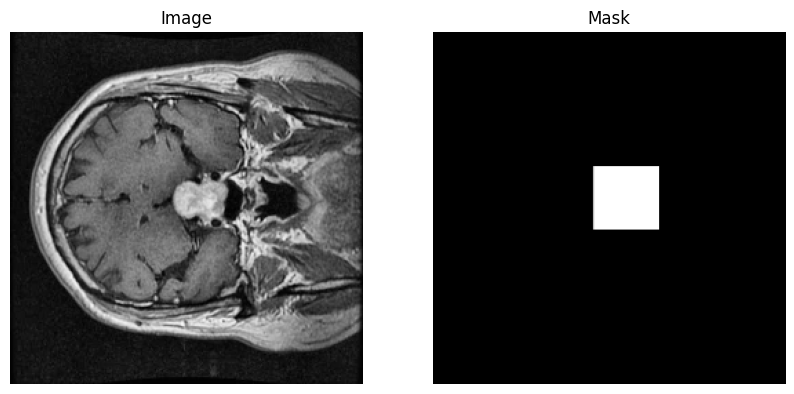

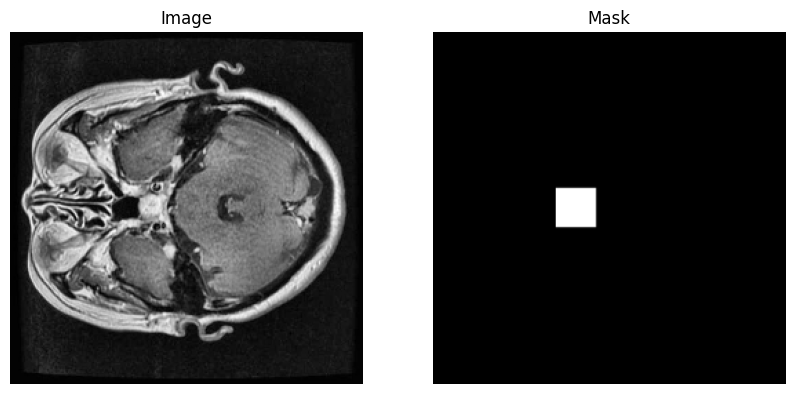

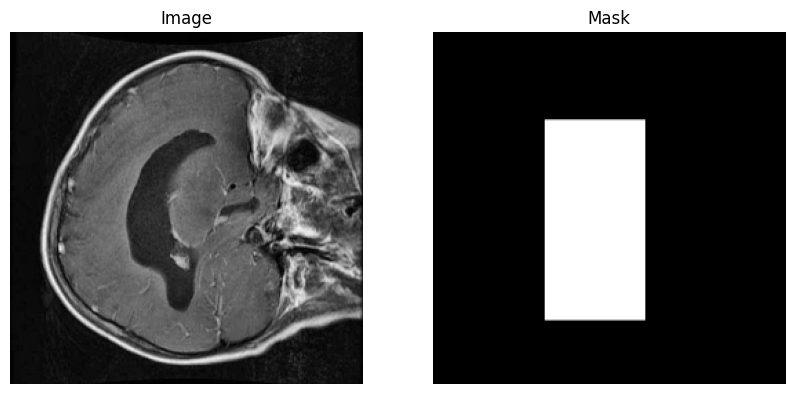

In [18]:
visualize_dataset(train_dataset)
visualize_dataset(val_dataset)

In [19]:
class PatchEmbedding(layers.Layer):
    def __init__( self, patch_size, embed_dim):
         super(PatchEmbedding, self). __init__()
         self.patch_size = patch_size
         self.embed_dim = embed_dim
         self.conv = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")
 
    def call(self, images):
         x = self.conv(images)
         x = tf.reshape(x, [tf.shape(x)[ 0], -1, self.embed_dim])
         return x

In [20]:
class TransformerBlock( layers.Layer):
    def __init__( self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super(TransformerBlock, self). __init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
        layers.Dense(mlp_dim, activation="gelu"),
        layers.Dropout(dropout_rate),
        layers.Dense(embed_dim),
        layers.Dropout(dropout_rate),
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
 
    def call(self, inputs):
         attn_output = self.attention(inputs, inputs)
         attn_output = self.dropout1(attn_output)
         out1 = self.norm1(inputs + attn_output)
         mlp_output = self.mlp(out1)
         return self.norm2(out1 + mlp_output)

In [21]:
def upsampling_block(inputs, filters):
     conv = layers.Conv2D(filters, kernel_size=( 3, 3), padding="same" )
     batch_norm = layers.BatchNormalization()
     activation = layers.Activation("relu")
     upsample =  layers.UpSampling2D(size=(2, 2), interpolation="bilinear")
     x = upsample(inputs)
     x = conv(x)
     x = batch_norm(x)
     x = activation(x)
     return x

<h1 id="ergdfffggs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center"> Model </h1>

In [22]:
class VisionTransformer(tf.keras.Model):
    def __init__( self, image_size, patch_size, embed_dim, num_heads, num_blocks, mlp_dim, decoder_filters, dropout_rate=0.1):
         super(VisionTransformer, self). __init__()
         self.patch_embed = PatchEmbedding(patch_size, embed_dim)
         height, width, _ = image_size
         self.num_patches = (height // patch_size) * (width // patch_size)
         self.pos_embed = self.add_weight(name="pos_embed" , shape=(1, self.num_patches, embed_dim),
         initializer=tf.initializers.RandomNormal(stddev=0.02), trainable=True)
         self.dropout = layers.Dropout(dropout_rate)
         self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, mlp_dim, dropout_rate) for _ in range(num_blocks)]
         self.norm = layers.LayerNormalization(epsilon=1e-6)
         self.upsample = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")
         self.conv_layers = [layers.Conv2D(filters, kernel_size=(3, 3), padding="same") for filters in decoder_filters]
         self.batch_norm_layers = [layers.BatchNormalization() for _ in decoder_filters]
         self.activation_layers = [layers.Activation( "relu") for _ in decoder_filters]
         self.final_conv = layers.Conv2D( 1, (1, 1), activation="sigmoid")
         
    def upsampling_block(self, inputs, idx):
         x = self.upsample(inputs)
         x = self.conv_layers[idx](x)
         x = self.batch_norm_layers[idx](x)
         x = self.activation_layers[idx](x)
         return x
        
    def call(self, images):
     
         batch_size = tf.shape(images)[ 0]
         patches = self.patch_embed(images)
         patches += self.pos_embed
         patches = self.dropout(patches)
         for block in self.transformer_blocks:
             patches = block(patches)
         patches = self.norm(patches)
         height, width = 256, 256
         num_channels = patches.shape[ - 1]
         x = tf.reshape(patches, [batch_size, height // 16, width // 16, num_channels] )
         print("Shape after transformer and reshaping:" , x.shape)
         for i in range( len(self.conv_layers)):
             x = self.upsampling_block(x, i)
             print(f"Shape after {i+1}th upsampling:" , x.shape)
         x = self.final_conv(x)
         print("Shape after final convolution:" , x.shape)
         return x

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Training </h1>

In [23]:
def dice_coef(y_true, y_pred, smooth=1e-6):
     y_true_f = K.flatten(y_true)
     y_pred_f = K.flatten(y_pred)
     intersection = K. sum(y_true_f * y_pred_f)
     return ( 2. * intersection + smooth) / (K. sum(y_true_f) + K. sum(y_pred_f) + smooth)

In [24]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [25]:
def combined_loss(y_true, y_pred):
     dice = dice_loss(y_true, y_pred)
     bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
     return 0.6 * dice + 0.4 * bce

In [26]:
def run_experiment(cmodel):
    
    
    cmodel.compile(
            loss=combined_loss,
            optimizer=optimizers.Adam(learning_rate=0.0005),
            metrics=[
                 'accuracy', dice_coef
            ],
        )

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    custom_callbacks = [
        callbacks.ModelCheckpoint("/tmp/checkpoint.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1, save_weights_only=False),
        callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss' , factor=0.5, patience=5,min_delta = 0.001, mode='auto', verbose=1),
         
    ]

   
    history = cmodel.fit(
        train_dataset.batch(8),
        validation_data=val_dataset.batch(8),
        batch_size=Config.batch_size,
        epochs=Config.epochs,
        callbacks=custom_callbacks,
    )
    evaluation= cmodel.evaluate(val_dataset.batch(8), return_dict=True)

     

    return history, cmodel, evaluation 

In [27]:
 
model = VisionTransformer(image_size=(256, 256, 3),patch_size=16,embed_dim=128, num_heads=8,
                              num_blocks=4, mlp_dim=256, decoder_filters=[128, 64, 32, 16], dropout_rate=0.1
)
model.summary(show_trainable=True)
print('Model is ready to be used')

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ patch_embedding (PatchEmbedding)    │ ?                            │   0 (unbuilt) │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ ?                            │   0 (unbuilt) │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ transformer_block                   │ ?                            │   0 (unbuilt) │    -    │
│ (TransformerBlock)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ transformer_block_1                 │ ?                            │   0 (unbuilt) │    -    │
│ (TransformerBlock)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ transformer_block_2                 │ ?                            │   0 (unbuilt) │    -    │
│ (TransformerBlock)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ transformer_block_3                 │ ?                            │   0 (unbuilt) │    -    │
│ (TransformerBlock)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ layer_normalization_8               │ ?                            │   0 (unbuilt) │    -    │
│ (LayerNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ up_sampling2d (UpSampling2D)        │ ?                            │   0 (unbuilt) │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_1 (Conv2D)                   │ ?                            │   0 (unbuilt) │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_2 (Conv2D)                   │ ?                            │   0 (unbuilt) │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_3 (Conv2D)                   │ ?                            │   0 (unbuilt) │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_4 (Conv2D)                   │ ?                            │   0 (unbuilt) │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ ?                            │   0 (unbuilt) │    -    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_1               │ ?                            │   0 (unbuilt) │    -    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_2               │ ?                            │   0 (unbuilt) │    -    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_3

 Total params: 32,768 (128.00 KB)

 Trainable params: 32,768 (128.00 KB)

 Non-trainable params: 0 (0.00 B)

Model is ready to be used


In [28]:

history, tmodel, evaluation  = run_experiment(model)

Epoch 1/20
Shape after transformer and reshaping: (None, 16, 16, 128)
Shape after 1th upsampling: (None, 32, 32, 128)
Shape after 2th upsampling: (None, 64, 64, 64)
Shape after 3th upsampling: (None, 128, 128, 32)
Shape after 4th upsampling: (None, 256, 256, 16)
Shape after final convolution: (None, 256, 256, 1)
Shape after transformer and reshaping: (None, 16, 16, 128)
Shape after 1th upsampling: (None, 32, 32, 128)
Shape after 2th upsampling: (None, 64, 64, 64)
Shape after 3th upsampling: (None, 128, 128, 32)
Shape after 4th upsampling: (None, 256, 256, 16)
Shape after final convolution: (None, 256, 256, 1)
Shape after transformer and reshaping: (None, 16, 16, 128)
Shape after 1th upsampling: (None, 32, 32, 128)
Shape after 2th upsampling: (None, 64, 64, 64)
Shape after 3th upsampling: (None, 128, 128, 32)
Shape after 4th upsampling: (None, 256, 256, 16)
Shape after final convolution: (None, 256, 256, 1)
    188/Unknown 58s 163ms/step - accuracy: 0.9125 - dice_coef: 0.1126 - loss: 0.

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Evaluation </h1>

In [29]:
def read_metrics():
    metric_holder=[mertic for mertic in evaluation.keys() ]
    value_holder = [round(value,2)*100 for value in evaluation.values()]

    return pd.DataFrame({'Metrics':metric_holder, 'Value (%)': value_holder})

evals = read_metrics()
evals

,Metrics,Value (%)
0,accuracy,96.0
1,dice_coef,51.0
2,loss,35.0


In [30]:
def make_plot(metric, hist):
  plt.plot(hist.history[metric], color='#8502d1')
  plt.plot(hist.history['val_'+metric], color='darkorange')
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='best' ) 
  plt.show()


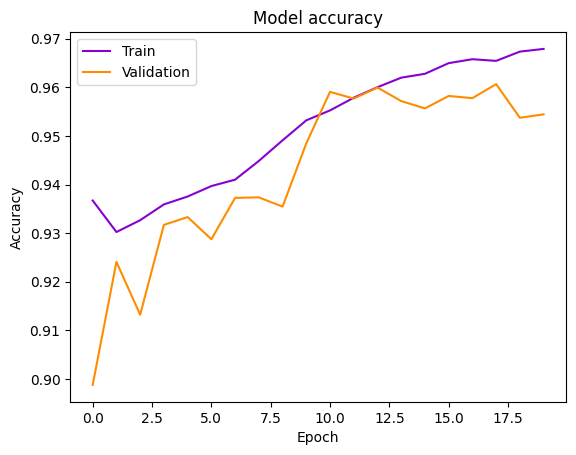

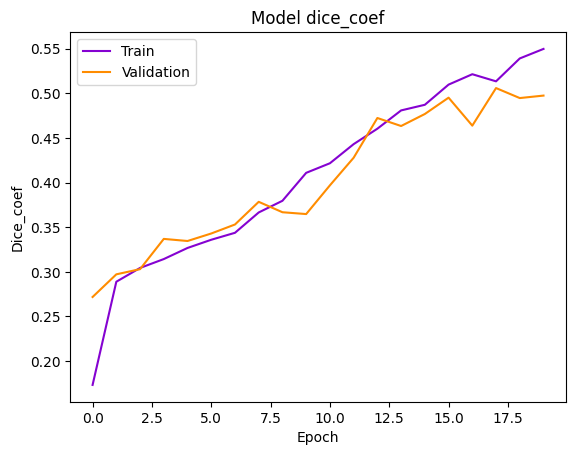

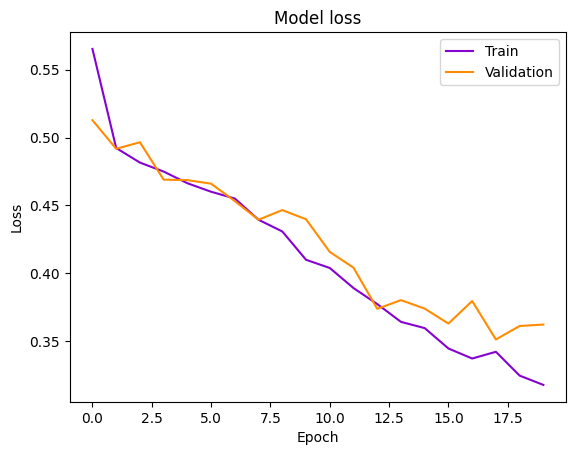

In [31]:
for i in evals['Metrics']:
    make_plot(i, history) 